In [1]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


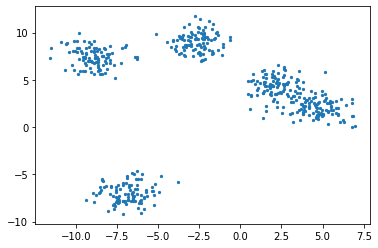

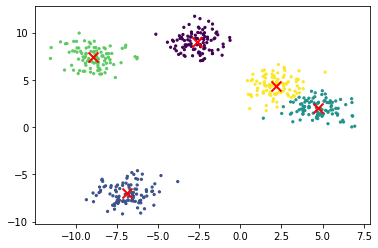

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs


def generate_data(n_samples: int = 500, centers: int = 5, random_state: int = 42) -> np.ndarray:
    """
    Generate random data to cluster using the make_blobs function from the sklearn library

    :param n_samples: Number of samples to generate
    :param centers: Number of clusters to generate
    :param random_state: Seed for random number generation
    :return: Generated data points
    """
    np.random.seed(random_state)
    X, y = make_blobs(n_samples=n_samples, centers=centers, random_state=random_state)
    return X


def plot_data(X: np.ndarray, assignments: np.ndarray = None, centroids: np.ndarray = None) -> None:
    """
    Plot the data points along with their cluster assignments and centroids (if provided)

    :param X: Data points
    :param assignments: Cluster assignments for each data point
    :param centroids: Centroids for each cluster
    """
    plt.scatter(X[:, 0], X[:, 1], c=assignments, s=5)
    if centroids is not None:
        plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, linewidths=2, color='r')
    plt.show()


def initialize_centroids_plusplus(X: np.ndarray, num_clusters: int) -> tf.Tensor:
    X = tf.constant(X, dtype=tf.float32)
    centroids = [X[np.random.randint(0, len(X))]]

    for _ in range(1, num_clusters):
        distances = tf.convert_to_tensor([min([tf.reduce_sum((x - c) ** 2).numpy() for c in centroids]) for x in X])
        probabilities = distances / tf.reduce_sum(distances)
        index = np.random.choice(len(X), p=probabilities.numpy())
        centroids.append(X[index])

    return tf.stack(centroids)

class KMeansClustering(tf.Module):
    def __init__(self, num_clusters: int, X: np.ndarray):
        super(KMeansClustering, self).__init__()
        self.num_clusters = num_clusters
        self.centroids = tf.Variable(initialize_centroids_plusplus(X, num_clusters))

    def __call__(self, X: tf.Tensor) -> tf.Tensor:
        X = tf.expand_dims(X, 1)
        centroids = tf.expand_dims(self.centroids, 0)
        distances = tf.reduce_sum((X - centroids) ** 2, axis=-1)
        assignments = tf.argmin(distances, axis=1)
        return assignments
    
    def update_centroids(self, X: tf.Tensor, assignments: tf.Tensor) -> None:
        centroids = []
        for i in range(self.num_clusters):
            cluster_points = X[assignments == i]
            if len(cluster_points) > 0:
                centroid = tf.reduce_mean(cluster_points, axis=0)
            else:
                centroid = self.centroids[i]
            centroids.append(centroid)
        self.centroids.assign(tf.stack(centroids))

# Update the train_model function to use TensorFlow
def train_model(model: KMeansClustering, X: np.ndarray, epochs: int = 300, tol: float = 1e-4) -> None:
    losses = []
    prev_loss = float('inf')
    for i in range(epochs):
        assignments = model(tf.constant(X, dtype=tf.float32))
        model.update_centroids(tf.constant(X, dtype=tf.float32), assignments)
        loss = tf.reduce_sum((model.centroids.numpy()[assignments] - X) ** 2)
        losses.append(loss.numpy())
        if prev_loss - loss < tol:
            break
        prev_loss = loss


def calculate_loss(X: np.ndarray, model: KMeansClustering) -> float:
    """
    Calculate the loss (WCSS) for the given data and model

    :param X: Data points
    :param model: KMeansClustering model
    :return: Loss value
    """
    assignments = model(tf.constant(X, dtype=tf.float32))
    loss = tf.reduce_sum((model.centroids.numpy()[assignments] - X) ** 2)
    return loss.numpy()


def find_best_model(X: np.ndarray, num_clusters: int, num_trials: int = 10) -> KMeansClustering:
    """
    Run the KMeansClustering model multiple times and return the best model (lowest loss)

    :param X: Data points
    :param num_clusters: Number of clusters
    :param num_trials: Number of trials to run
    :return: Best KMeansClustering model
    """
    best_model = None
    best_loss = float('inf')

    for _ in range(num_trials):
        model = KMeansClustering(num_clusters, X)
        train_model(model, X)
        loss = calculate_loss(X, model)
        if loss < best_loss:
            best_model = model
            best_loss = loss

    return best_model


# Generate and plot the random data
X = generate_data()
plot_data(X)

# Find the best model after running K-Means multiple times
best_model = find_best_model(X, num_clusters=5)

# Train best_model and plot the loss
train_model(best_model, X)

# Get the final cluster assignments and centroids
assignments = best_model(tf.constant(X, dtype=tf.float32)).numpy()
centroids = best_model.centroids.numpy()

# Plot the data points with their cluster assignments and centroids
plot_data(X, assignments, centroids)